## Source

code from: https://www.youtube.com/watch?v=QIUxPv5PJOY

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  # to colorize the stylesheet

In [ ]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

In [ ]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.629209
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.697079
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.838044
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.972249
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.951672
...,...,...,...,...,...,...
2019-12-11,67.775002,67.125000,67.202499,67.692497,78756800.0,66.899139
2019-12-12,68.139999,66.830002,66.945000,67.864998,137310400.0,67.069626
2019-12-13,68.824997,67.732498,67.864998,68.787498,133587600.0,67.981300


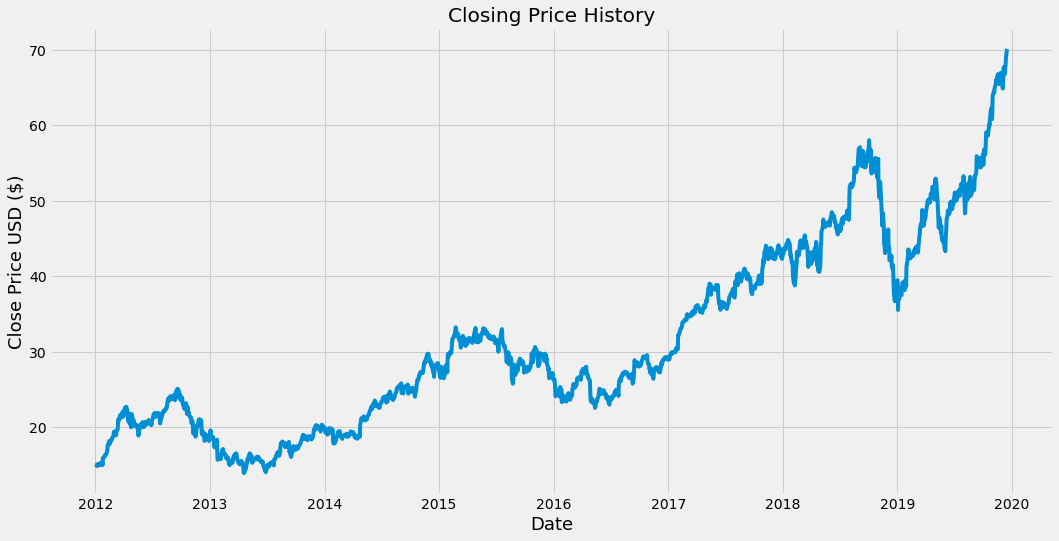

In [ ]:
# visualize closing price history
plt.figure(figsize=(16, 8))
plt.title("Closing Price History")
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
# Create a new dataframe with only close column
data = df.filter(['Close'])
# Convert the DF to a numpy array
dataset = data.values
# Get the numebr of rows to train the model on
# Get the 80% (0.8) of data & round it using math.ceil
training_data_len = math.ceil(len(dataset) * .8)

In [ ]:
training_data_len

1603

In [ ]:
# Scale (Normalize) the data before preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
scaled_data

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [ ]:
# Create the training dataset
 
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
 
# Split data to x_train & y_train
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 61:
    print("x_train: ", "\n", x_train, "\n", "y_train: ", "\n", y_train)

x_train:  
 [array([0.01316509, 0.01457063, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862191, 0.02173194,
       0.02453668, 0.02367172, 0.01893355, 0.02345548, 0.01900352,
       0.03569838, 0.03440732, 0.0360927 , 0.03973694, 0.04194384,
       0.0417594 , 0.0410789 , 0.04397903, 0.04670744, 0.04979839,
       0.05479095, 0.0652785 , 0.06543749, 0.07127594, 0.07563885,
       0.06814049, 0.07102789, 0.07097066, 0.07906688, 0.07791571,
       0.08004628, 0.08387497, 0.08600558, 0.09214292, 0.09661394,
       0.09790501, 0.09835659, 0.09071194, 0.08886753, 0.08914103,
       0.09632778, 0.09835024, 0.10269409, 0.11293358, 0.12659476,
       0.12403805, 0.1240444 , 0.13392141, 0.13701237, 0.13481179,
       0.13280207, 0.13070964, 0.13766105, 0.14243103, 0.14442805])] 
 y_train:  
 [0.13949272033425864]
x_train:  
 [array([0.01316509, 0.01457063, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862191, 0.02173194

In [ ]:
# Convert x_train & y_train to numpy arrays to use it on LSTM
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape

[[0.01316509 0.01457063 0.01748985 ... 0.13766105 0.14243103 0.14442805]
 [0.01457063 0.01748985 0.02026915 ... 0.14243103 0.14442805 0.13949272]
 [0.01748985 0.02026915 0.01984303 ... 0.14442805 0.13949272 0.13293563]
 ...
 [0.52177011 0.51927696 0.51669488 ... 0.5857448  0.59767603 0.5912207 ]
 [0.51927696 0.51669488 0.51322235 ... 0.59767603 0.5912207  0.58926183]
 [0.51669488 0.51322235 0.51958863 ... 0.5912207  0.58926183 0.58164901]]


In [ ]:
# Reshape the data (input of LSTM should be 3-dim)
# (number of rows we have "1543", number of time steps "60", number of features "closing price": 1)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(1543, 60, 1)

In [ ]:
# Build the LSTM Model
model = Sequential()
# 50 neurons, True because we're using another LSTM layer,
# for the first layer we use input shape(number of time steps, number of features)
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))  # False because we don't have any LSTM further
model.add(Dense(25))  # 25 neurons
model.add(Dense(1))

In [ ]:
# Compile the model
# optimizer used to improve loss function & loss function measures how well model did on training
model.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
# Train the Model
# batch_size : total number of examples present in a single batch
# epochs : number of iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 53s 23ms/step - loss: 0.0025


In [ ]:
# Create a testing dataset
# Create a new array containing the scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
# Create the dataset x_test & y_test
x_test = []
# y_test : all of the values we want our model to predict
# contains actual values (60 first values)
y_test = dataset[training_data_len: , :]

# Create x_test contains past 60 values
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
# Convert the data to a numpy array to use it in LSTM model
x_test = np.array(x_test)

In [ ]:
# Reshape the data (2dim to 3dim)
# (reshape x_test, (number of samples 'rows'), (number of timesteps 'columns'), (number of features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Get the models predicted price values (x_test)
predictions = model.predict(x_test)
# Inverse transform the data (unscaling the values) to contain...
# exact same values that y_test contains
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Evaluate the model by getting the Root Mean Squared Error (RMSE)
# the lower the value, the better the model fit
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.8651253986358642

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


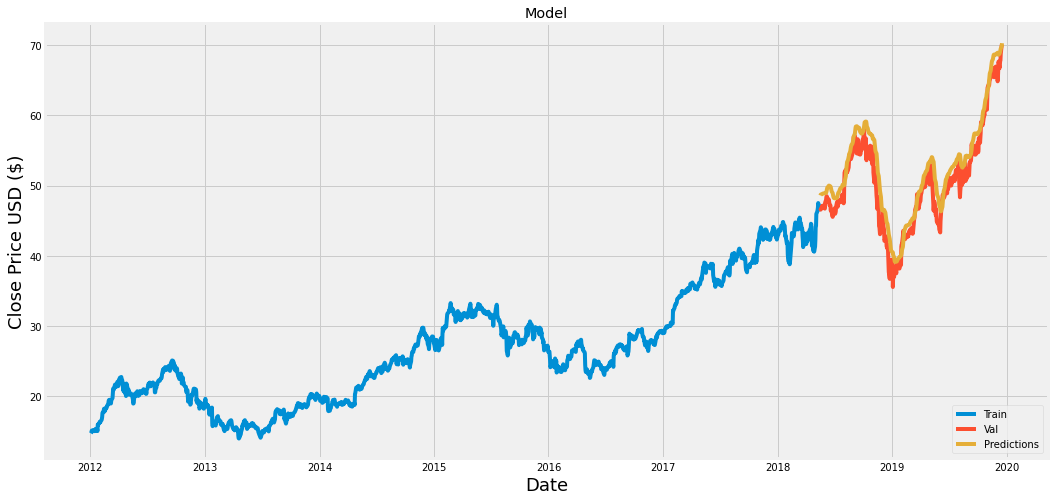

In [ ]:
# Plot the data
train = data[: training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid & predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,48.594776
2018-05-18,46.577499,48.717716
2018-05-21,46.907501,48.762836
2018-05-22,46.790001,48.795300
2018-05-23,47.090000,48.804474
...,...,...
2019-12-11,67.692497,69.086586
2019-12-12,67.864998,69.297340
2019-12-13,68.787498,69.530769


In [ ]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

In [ ]:
# Create a new dataframe
new_df = apple_quote.filter(['Close'])
# Get the last 60 day closing price of values & convert the df to an array
last_60_days = new_df[-60:].values
# Scale the data (0-1)
# not using fit transform because we want to transform those same Min & Max values that we used when we first transformed the data
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the past 60 days to the X_test
X_test.append(last_60_days_scaled)
# Convert the X_test dataset to a numpy array to use in LSTM
X_test = np.array(X_test)
# Reshape from 2dim to 3dim
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predcited scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)  # price of 18 December 2019

[[70.77503]]


In [ ]:
# Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')

In [ ]:
print(apple_quote2['Close'])

Date
2019-12-18    69.934998
Name: Close, dtype: float64


## Keep Going!

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# To colorize stylesheets & make them beautiful!
plt.style.use('fivethirtyeight')

In [2]:
# Mount Google Drive to Download the Dataset

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6jqSrRIPrpv6LxgEzWdom3oJldrJABt6LisY8hJE5O3-Ad7fuzgpI
Mounted at /content/drive


In [3]:
# Store the CSV file into the <df> variable
df = pd.read_csv('/content/drive/MyDrive/tseStockAnalyze/vbmellat.csv')
# Show the DataFrame
df

,Unnamed: 0,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,2535,2009-02-18,1050.0,1050.0,1050.0,1050.0,347393807250,330851245,800,1000.0,1050.0
1,2534,2009-02-21,1051.0,1076.0,1042.0,1050.0,352194689892,335334212,6457,1050.0,1057.0
2,2533,2009-02-22,1065.0,1074.0,1055.0,1065.0,8981292784,8435464,603,1050.0,1055.0
3,2532,2009-02-23,1066.0,1067.0,1059.0,1061.0,9090532333,8570222,937,1065.0,1060.0
4,2531,2009-02-25,1061.0,1064.0,1050.0,1058.0,7863032258,7434309,616,1061.0,1060.0
...,...,...,...,...,...,...,...,...,...,...,...
2531,4,2021-04-27,4210.0,4310.0,4180.0,4250.0,805642623200,189399476,6001,4150.0,4290.0
2532,3,2021-04-28,4360.0,4500.0,4330.0,4490.0,2422315869670,539813093,15192,4250.0,4500.0
2533,2,2021-05-01,4600.0,4640.0,4400.0,4500.0,1272892280650,282682294,10773,4490.0,4470.0
2534,1,2021-05-02,4600.0,4740.0,4470.0,4610.0,2264635342054,491265655,17752,4500.0,4535.0


In [4]:
# Drop <Unnamed: 0> Column
df = df.drop(['Unnamed: 0'], axis=1)
# Convert Date column to <datetime> object to prevent further errors
df['date'] = pd.to_datetime(df['date'])
# Set Date as Index
df = df.set_index(pd.DatetimeIndex(df['date'].values))
df

,date,open,high,low,adjClose,value,volume,count,yesterday,close
2009-02-18,2009-02-18,1050.0,1050.0,1050.0,1050.0,347393807250,330851245,800,1000.0,1050.0
2009-02-21,2009-02-21,1051.0,1076.0,1042.0,1050.0,352194689892,335334212,6457,1050.0,1057.0
2009-02-22,2009-02-22,1065.0,1074.0,1055.0,1065.0,8981292784,8435464,603,1050.0,1055.0
2009-02-23,2009-02-23,1066.0,1067.0,1059.0,1061.0,9090532333,8570222,937,1065.0,1060.0
2009-02-25,2009-02-25,1061.0,1064.0,1050.0,1058.0,7863032258,7434309,616,1061.0,1060.0
...,...,...,...,...,...,...,...,...,...,...
2021-04-27,2021-04-27,4210.0,4310.0,4180.0,4250.0,805642623200,189399476,6001,4150.0,4290.0
2021-04-28,2021-04-28,4360.0,4500.0,4330.0,4490.0,2422315869670,539813093,15192,4250.0,4500.0
2021-05-01,2021-05-01,4600.0,4640.0,4400.0,4500.0,1272892280650,282682294,10773,4490.0,4470.0
2021-05-02,2021-05-02,4600.0,4740.0,4470.0,4610.0,2264635342054,491265655,17752,4500.0,4535.0


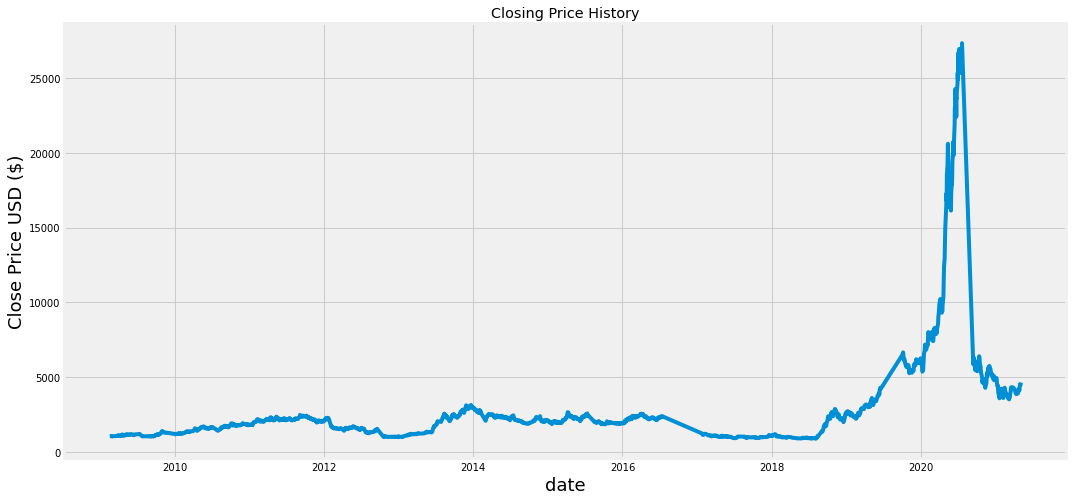

In [5]:
# Visualize closing price history
# Set figure size (width, height)
plt.figure(figsize=(16, 8))
# Set plot Title
plt.title("Closing Price History")
# Show <close> column data
plt.plot(df['close'])
# Set date label as x_axis
plt.xlabel('date', fontsize=18)
# Set y axis title
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [6]:
# Create a new dataframe with only close column
data = df.filter(['close'])
# Convert the DF to a numpy array (list of lists[close price])
dataset = data.values
# Get the number of rows to train the model on
# Get the 80% (0.8) of data & round it using math.ceil
training_data_len = math.ceil(len(dataset) * .8)

In [7]:
training_data_len

2029

**`fit()`**: takes the `scaler` features & computes the *mean(μ)* and *standard deviation(σ)* of the features for later scaling (& transform).<br>
**`transform()`**: uses previously computed *mean* & *standard deviation* to autoscale the data (subtract mean from all values & divide by std).<br>
For X training set, we use `fit_transform()` because we need to compute mean and std, and then use it to autoscale the data.<br>
For X test set, we already have the mean and std, so we only do the "transform" part.

In [8]:
# Scale (Normalize) the data before preprocessing (between 0 - 1)
scaler = MinMaxScaler(feature_range=(0, 1))
# fit() [training] & transform() the scaler
scaled_data = scaler.fit_transform(dataset)

In [9]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
scaled_data

array([[0.00567537],
       [0.00594022],
       [0.00586455],
       ...,
       [0.13507378],
       [0.13753311],
       [0.14150586]])

In [11]:
# Create the training dataset

# Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]

# Split data to x_train & y_train
x_train = []
y_train = []

# Start for loop from 60, stop on 2028
# takes previous 60 days to predict next day
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 61:
    print("x_train: ", "\n", x_train, "\n", "y_train: ", "\n", y_train)

x_train:  
 [array([0.00567537, 0.00594022, 0.00586455, 0.00605373, 0.00605373,
       0.0057132 , 0.00537268, 0.00597806, 0.00586455, 0.00590238,
       0.00601589, 0.00601589, 0.00597806, 0.00605373, 0.00605373,
       0.00609156, 0.00597806, 0.00609156, 0.00616723, 0.00681044,
       0.00741582, 0.00798335, 0.00802119, 0.00707529, 0.00775634,
       0.00737798, 0.00756716, 0.00752932, 0.00688611, 0.00684828,
       0.00616723, 0.00654559, 0.00749149, 0.00783201, 0.00775634,
       0.00756716, 0.00934544, 0.01048051, 0.0086644 , 0.00862656,
       0.00756716, 0.00828604, 0.00779417, 0.00786984, 0.00768067,
       0.00756716, 0.00756716, 0.00832387, 0.0091941 , 0.01017783,
       0.01104805, 0.01036701, 0.0097238 , 0.00964813, 0.00900492,
       0.00885358, 0.00983731, 0.00991298, 0.01044268, 0.01021566])] 
 y_train:  
 [0.010594021944759745]
x_train:  
 [array([0.00567537, 0.00594022, 0.00586455, 0.00605373, 0.00605373,
       0.0057132 , 0.00537268, 0.00597806, 0.00586455, 0.0059023

In [12]:
print(scaled_data)
print(train_data)

[[0.00567537]
 [0.00594022]
 [0.00586455]
 ...
 [0.13507378]
 [0.13753311]
 [0.14150586]]
[[0.00567537]
 [0.00594022]
 [0.00586455]
 ...
 [0.03711691]
 [0.04033295]
 [0.04404086]]


In [13]:
# Convert x_train & y_train to numpy arrays to use it on LSTM
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
x_train.shape

(1969, 60)

In [15]:
# Reshape the data (input of LSTM should be 3-dim)
# (number of rows we have "1969", number of time steps "60", number of features "closing price": 1)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(1969, 60, 1)

In [16]:
# Build the LSTM Model

# Create Sequential model (Linear stack of models), used this because we don't need more than 1 output
model = Sequential()
# 50 neurons, True because we're using another LSTM layer,
# only for the first layer we use input_shape(number of time steps, number of features)
# input_shape=(1969, 1) : to train only one unit at a time
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))  # False because we don't have any LSTM further
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer
model.add(Dense(25))  # 25 neurons
model.add(Dense(1))

In [17]:
# Compile the model

# optimizer used to improve loss function & loss function measures how well model did on training
model.compile(optimizer='Adam', loss='mean_squared_error')

In [18]:
# Train the Model
# batch_size : total number of examples present in a single batch (comparing samples to calculate the correct weight)
# batch_size=1 : 1 sample from the training dataset will be used to estimate the error before the weights are updated
# epochs : number of iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=1)

1969/1969 [==============================] - 31s 6ms/step - loss: 6.9945e-05


In [ ]:
# Create a testing dataset
# Create a new array containing the scaled values from index 1969 to 2536
test_data = scaled_data[training_data_len - 60: , :]
# Create the dataset x_test & y_test
x_test = []
# y_test : all of the values we want our model to predict
# contains actual values (unscaled 60 first values)
y_test = dataset[training_data_len: , :]

# Appends to x_test contains past 60 values
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
# Convert the <x_test> data to a numpy array to use it in LSTM model
x_test = np.array(x_test)

In [ ]:
# Reshape the data (2dim to 3dim)
# (reshape x_test, (number of samples 'rows'), (number of timesteps 'columns'), (number of features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Get the models predicted price values (x_test)
predictions = model.predict(x_test)
# Inverse transform the data (unscaling the values) to contain...
# exact same values that y_test contains
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Evaluate the model by getting the Root Mean Squared Error (RMSE)
# the lower the value, the better the model fit
#rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse = np.sqrt(np.mean((predictions- y_test)**2))
rmse

In [ ]:
# Plot the data
train = data[: training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid & predicted prices
valid

In [ ]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

In [ ]:
# Create a new dataframe
new_df = apple_quote.filter(['Close'])
# Get the last 60 day closing price of values & convert the df to an array
last_60_days = new_df[-60:].values
# Scale the data (0-1)
# not using fit transform because we want to transform those same Min & Max values that we used when we first transformed the data
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the past 60 days to the X_test
X_test.append(last_60_days_scaled)
# Convert the X_test dataset to a numpy array to use in LSTM
X_test = np.array(X_test)
# Reshape from 2dim to 3dim
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predcited scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)  # price of 18 December 2019

In [ ]:
# Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')

In [ ]:
print(apple_quote2['Close'])